# Support vector machines and surrogates

In this lessow, we will learn 

- How Support vector machine (SVM) classifiers work and how to use them on different kinds of data
- How to train a SVM to decode the presence or absence of a stimulus from neural activity
- How to assess the performance of a classifier using shuffling methods to create surrogate data

### Introduction

In this lecture, we will look at SVMs, a widely used group of classification algorithms. We'll look at how they can be used to identify stimulus from patterns of neural activity.
_____

### Support vector machines (SVMs)

The SVM is a machine learning algorithm that learns to predict to which of different classes each data point belongs to. To get some intuition about the algorithm, we will start with the case of a **linear SVM** with two classes

### **Linear SVM**

Let our data consist of $N$ pairs $(x_i, y_i)$ with our set of features $x_i$ and labels $y_i$. First, let's consider the case of **linearly separable data**, i.e., data in which classes can be separeted by a straight line.

In that case, we candraw a hyperplane (the **decision boudary**) that perfectly separates the twp classes in many different ways. We look for the linear decision boundary

$$x^Tw +b =0$$

such that the **margin $M$** between the two classes is maximal. To do so, we want to find the largest $M$ such that, for every data point in our set, the **signed/orthogonal distance** from the boundary - $y_i(x_i^Tw + b)$ - is larger than $M$. This amounts to solving the following maximization problem:

$$\max_{w,b,||w||=1}M$$

with constraints:

$$y_i(x_i^Tw + b) \geq M, \ \ \forall_i$$

<img src='svm_linear.webp' width='500'>

### **Non-separable data**

If the data are not linearly separable, the margin problem doesn't have a solution.

However, we can soften our margin constraint by introducing a new set of $N$ variables $\xi_i$, often called **slacks**, to quantify by how much our margin constraint is violated. We can require 

$$y_i(x_i^Tw + b) \geq M(1-\xi_i), \ \ \forall_i$$

with 

$$\xi_i \geq 0, \ \ \sum_{\xi_i} \leq K$$

$K$ quantifies the total amount of slack that we want to allow: a larger $K$ allows for more margin violation and vice versa. We may think of $\xi_i$ as the **relative amount of margin violation** for point $i$. *Note that $\xi_i > 1$ cooresponds to a misclassification of the corresponding data point.*

If we drop the norm constraint on $w$ and define $M = 1/||w||$, we obtain the following minimisation problem:

$$\min ||w||$$

with constraints 

$$y_i(z_i^Tw + b) \geq (1-\xi_i)$$

$$\xi_i \geq 0 \ \ \forall_i \ \ \ \ \ \ \sum_{\xi_i} \leq KK$$

In this lesson, we will use the `sklearn` implementation of SVMs.
_____

### Example: SVMs on synthetic data

In [1]:
from sklearn import svm
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pickle
from utils import download_data

# Download data
download_data('https://surfdrive.surf.nl/files/index.php/s/tEenLK693lU9v01')

In [ ]:
# Linearly separable data
x_sep, y_sep = make_blobs(1000, 2, centers=[[-1,0],[1,0]], cluster_std = .3)

# Non-linaerly separable data
x_nsep, y_nsep = make_blobs(1000, 2, centers=[[-1,0],[1,0]], cluster_std = .8)

print(y_nsep)

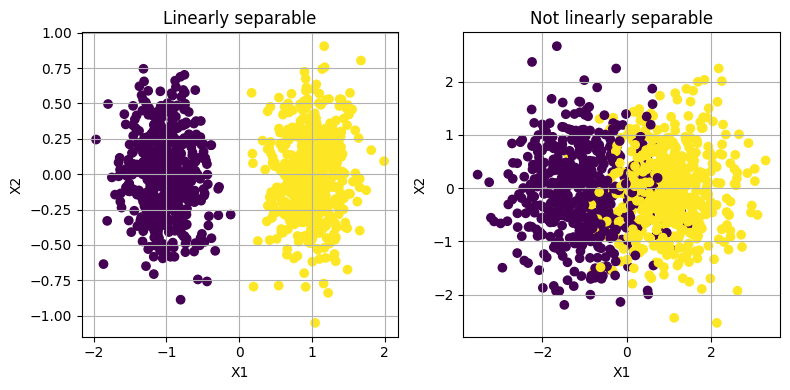

In [3]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title('Linearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(x_sep[:,0], x_sep[:,1], c = y_sep)
plt.grid()

plt.subplot(1,2,2)
plt.title('Not linearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(x_nsep[:,0], x_nsep[:,1], c = y_nsep)
plt.grid()

plt.tight_layout()

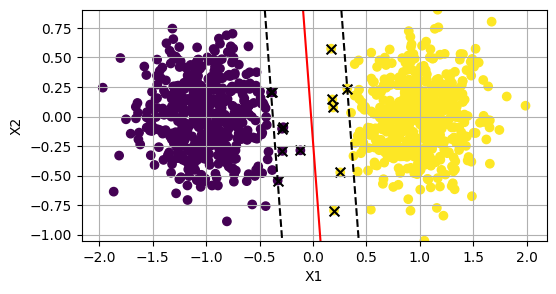

In [4]:
# Use SVM from scikit learn
# Create model object
svc_model = svm.SVC(kernel='linear')

# Fit the model
svc_model.fit(x_sep, y_sep)

plt.figure(figsize=(6,3))
plt.scatter(x_sep[:, 0], x_sep[:,1], c= y_sep)

# Constructing a hyperplane
w = svc_model.coef_[0]
b = svc_model.intercept_[0]

x_points = np.linspace(-1,1)
y_points = -(w[0]/w[1]) * x_points - b/ w[1]

plt.plot(x_points, y_points, 'r')

# Support vectors
plt.scatter(svc_model.support_vectors_[:,0],
            svc_model.support_vectors_[:,1],
            s = 50, c = 'k', marker='x')

# Unit vector
w_hat = w / np.sqrt(np.sum(w**2))

# Margin
margin = 1 / np.sqrt(np.sum(w**2))

# Point from the margin limits
decision_boundary = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary + w_hat * margin
points_of_line_below = decision_boundary - w_hat * margin

# Plot margin lines
plt.plot(points_of_line_above[:,0], points_of_line_above[:,1], 'k--')
plt.plot(points_of_line_below[:,0], points_of_line_below[:,1], 'k--')

plt.ylim([min(x_sep[:,1]),max(x_sep[:,1])])
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()

An important feature of SVMs with an **hard margin** (i.e., slack $K = 0$) is that they are only sensible to data points $x_i$ that **lie on the margin** (the crossed blobs above). These points are called the **support vectors**!
_____

### Example: Decoding the stimulus identity from neural activity

Let's now look at how we can use SVM to decode neural activity.

We'll use a dataset built to simulate the following scenario: a mouse is presented with a series of 100 sound stimuli: 50 of type A and the other 50 of type B, randomly intermixed. Each sound is presented during 2 seconds with a 3 second interval. Whilst the animal is exposed to this seris of sounds, we record the activity of $N$ neurons.

We are posed with the question: *Is it possible to tell, by inspection of the neural activity only, which sound the animal was perceiving at each time?*

To answer this question, we'll divide the 2 seconds of sound presentation in 100 ms long time bons and train a linear SVM to decode if either sound A or B was presented.

In [6]:
# Import data
with open('data/simulated_data1.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times   = data['spike_times'] # Spike times of each of the 20 cells
stim_onsets   = data['stim_onsets']
stim_type     = data['stim_type']   # Number of trials
stim_duration = data['stim_duration']

In [10]:
# Bin the data into 100 ms wide bins
onset, offset = 1, 1
bin_width = 0.1 #seconds
bins = np.arange(-onset, stim_duration + offset + bin_width, bin_width)

n_cells = len(spike_times)
n_trials = len(stim_type)

x = np.zeros((n_cells, n_trials, len(bins) - 1))

for cell in range(n_cells):
    for trial in range(n_trials):

            # Select the spikes from this trial
            sp_indx = np.logical_and(spike_times[cell] > stim_onsets[trial] - onset,
                                     spike_times[cell] < stim_onsets[trial]+ stim_duration + offset)
        
            sp_center = spike_times[cell][sp_indx] - stim_onsets[trial]
            spike_count, _ = np.histogram(sp_center, bins)
            x[cell, trial,:] = spike_count

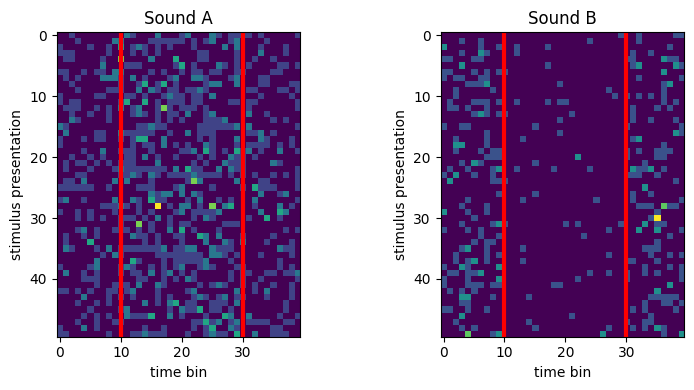

In [16]:
''' The dataset `x` has shape [n_neurons x n_stimuli, n_time_bins].
    We can plot the activity of a given neuron over the course 
    of the stimulus presentation for each of the 50 presentations 
    of stimulus A and stimulus B'''

neuron = 3

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Sound A')
plt.imshow(x[neuron][stim_type==1])
plt.axvline(x=10,c='r',linewidth=3)
plt.axvline(x=30,c='r',linewidth=3)
plt.xlabel('time bin')
plt.ylabel('stimulus presentation')

plt.subplot(1,2,2)
plt.title('Sound B')
plt.imshow(x[neuron][stim_type==2])
plt.axvline(x=10,c='r',linewidth=3)
plt.axvline(x=30,c='r',linewidth=3)
plt.xlabel('time bin')
plt.ylabel('stimulus presentation')

plt.tight_layout()

As you can see, the activity of some neurons is clearly different between the stimuli. But how much information is the population carrying as a whole? For that, we use decoding!
_____

### Cross-validation

Cross-validation is a technique widely used in ML to make sure we are not over fitting the data. It consists in splitting the dataset into two parts, the first for training and the second for validation. The splitting procedure can be repeated several times, training/testing everytinme on a different portion of the data. 

In [17]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5

avg_performance = []
std_performance = []

for time_bin in range(x.shape[-1]):

    kf = StratifiedKFold(n_splits, shuffle = True)
    fold_performance = []

    for train_index, test_index in kf.split(x[:, :, time_bin].T, stim_type):

        x_train, x_test = x[:, train_index, time_bin].T, x[:, test_index, time_bin].T
        y_train, y_test = stim_type[train_index], stim_type[test_index]

        clf = svm.LinearSVC(max_iter = 1000)
        clf.fit(x_train, y_train)
        fold_performance.append(clf.score(x_test, y_test))

    avg_performance.append(np.mean(fold_performance))
    std_performance.append(np.std(fold_performance))

avg_performance = np.asarray(avg_performance)
std_performance = np.asarray(std_performance) 

Text(0, 0.5, 'Decoding performance')

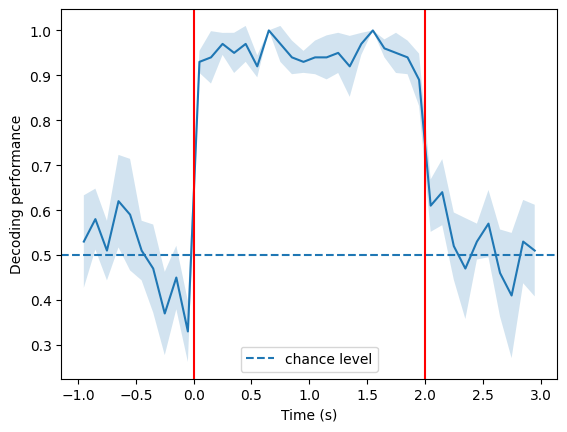

In [18]:
'''We now have an average model performance and the corresponding standard deviation
    for each of the time bins!Let's plot the time course'''

bin_centers = [(bins[i+1] + bins[i])/2 for i in range(len(bins) - 1)]
plt.plot(bin_centers, avg_performance)
plt.fill_between(bin_centers, avg_performance - std_performance,
                 avg_performance + std_performance, alpha=0.2)

plt.axhline(y=0.5,linestyle='--',label='chance level')
plt.axvline(x=0,c='r')
plt.axvline(x=2,c='r')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Decoding performance')

### Assessing significance with surrogate data

How can we distinguish actual information from random fluctuations?

To assess if the performance of our classifier is significantly different from what would be expected by chance, we need a statisticall **null model** to compare to.

A powerfull way to construct null models is to use shuffling procedures to destroy the structure of the data, in our case, this corresponds to the relationship between features and labels. We then check ehat results our classifier gives for that case, corresponding to the performance expected by chance decoding.

If we repeat this procedure a number of times, we can get a **surrogate distribution**. This method is a very versatile tool to discriminate signal from noise in many real-worl situations, in which often the unedrlying distribution of the data is unknown or complex.

However, this kind of shuffling can disrupt or even preserve different features of the structure of our data and always comes with an underlying hypothesis one needs to be aware of!
_____

### Example: Computing significance on decoding performance


In [22]:
from tqdm import tqdm 

n_shuffles = 100 # number of surrogates for each bin
performance = []
surrogate_performance = []

for time_bin in range(x.shape[-1]):
        
        kf = StratifiedKFold(n_splits=2)
        fold_performance = []
        surrogate_fold_performance = []

        for train_index, test_index in kf.split(x[:,:,time_bin].T,stim_type):
            print(f'Computing time bin {time_bin}/{x.shape[-1]}')

            X_train, X_test = x[:,train_index,time_bin].T, x[:,test_index,time_bin].T
            y_train, y_test = stim_type[train_index], stim_type[test_index]

            clf = svm.LinearSVC(loss='hinge')
            clf.fit(X_train, y_train)
            fold_performance.append(clf.score(X_test,y_test))


            for s in tqdm(range(n_shuffles)):
                stim_type_shuff = np.random.permutation(stim_type)
                y_train_shuff, y_test_shuff = stim_type_shuff[train_index], stim_type_shuff[test_index]
                clf = svm.LinearSVC(loss='hinge')
                clf.fit(X_train, y_train_shuff)
                surrogate_fold_performance.append(clf.score(X_test,y_test_shuff))


        performance.append(np.mean(fold_performance))
        surrogate_performance.append(surrogate_fold_performance)

performance = np.asarray(performance)
surrogate_performance = np.asarray(surrogate_performance)

Computing time bin 0/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 0/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 1/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 1/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 2/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 2/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 3/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 3/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 4/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 4/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 46%|████▌     | 46/100 [00:00<00:00, 458.39it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter

Computing time bin 5/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 5/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 6/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 6/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 7/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 7/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 8/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 8/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 9/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 9/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 10/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 10/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 11/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 11/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 12/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 12/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 13/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 13/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 14/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 14/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 15/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 15/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 16/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 16/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 17/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 17/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 18/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 18/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 19/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 19/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 20/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 20/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 21/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 21/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 22/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 22/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 23/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 23/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 24/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 24/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 25/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 25/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 26/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 26/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 27/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 27/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 28/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 28/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 29/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 29/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 30/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 30/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 31/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 31/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 32/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 32/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 33/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 33/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 34/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 54%|█████▍    | 54/100 [00:00<00:00, 537.56it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter

Computing time bin 34/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 35/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 35/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 36/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 36/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 37/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 37/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 24%|██▍       | 24/100 [00:00<00:00, 238.24it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter

Computing time bin 38/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 38/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 39/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

Computing time bin 39/40


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\sklearn\sv

We have computed a surrogate distribution for each bin. Let us now look at what this distribution looks like and how the classifier's performance compares to such distributions. Here are two examples for time bin 0 and 20, inside and outside stimulus presentation, respectively.

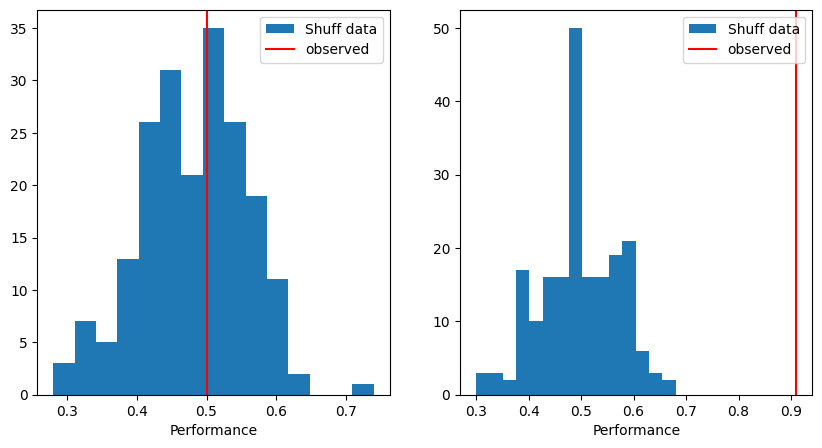

In [23]:
plt.figure(figsize=(10,5))

# Plot for bin 0
plt.subplot(1,2,1)
plt.hist(surrogate_performance[0], bins=15,label='Shuff data')
plt.axvline(x=performance[0],c='r',label='observed')
plt.xlabel('Performance')
#sns.despine()
plt.legend()

# Plot for bin 20 
plt.subplot(1,2,2)
plt.hist(surrogate_performance[20],bins=15,label='Shuff data')
plt.axvline(x=performance[20],c='r',label='observed')
plt.xlabel('Performance')
#sns.despine()
plt.legend()

As we can see, when no information about the stimulus is present, the observed performance falls well within the shuffled distribution. However, when the stimulus is present, the classification performance is clearly larger than expected by chance!

____

## **KEY POINTS**

- Linear SVMs fit the largest possible margin between data classes, with penalisation for points that fall on the wrong side of the margin.
- SVMs can be used to decode stimulus identity by training a classifier to predict the identity of the presented stimulus from the neural activity at the corresponding time
- We can build a statistical null model by shuffling the data and destroying the relationship between features and labels. This procedure can help us assess the effect size and statitical significance of out classification.